# Comparing distributions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend import Legend
import matplotlib.gridspec as grid_spec

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [3]:
from scipy.stats import norm, kstest, probplot, levene, mannwhitneyu, ttest_ind, kruskal, kurtosis, skew
from itertools import combinations

In [4]:
from statsmodels.stats.multitest import multipletests

In [5]:
# %matplotlib notebook

In [6]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 11,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [7]:
def hypo_testing(test_statistic, n):
    '''
    Functions that performs hypothesis testing and calculate the critical value
    of the K-S test
    Inputs:
        test_statistic: float containing the value of the test statistic
        n: integer containg the sample size. 
    '''
    if n > 50:
        critical_value = 1.63 / np.sqrt(n)
    
    if test_statistic > critical_value:
        return 'Reject Ho'
    else:
        return 'Not enough evidence to reject Ho'

In [8]:
def pdf_normal(mean, std, x):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(- (x - mean)**2 / (2 * std**2))

Load data

In [9]:
df = pd.read_table('../phylogeny/place/fine_all.tsv', index_col = 0)
df.shape

(5380, 22)

In [10]:
# Reformat shape column
def refShape(s):
    if 'shaped' in str(s):
        return s.split('-')[0]
    # Cyanobacteira - modeled as sphere
    elif str(s) == 'sphere/spheroid':
        return 'sphere'
    elif str(s) in ['rods']:
        return 'rod'
    elif '/' in str(s):
        return '-'.join(s.split('/'))
    else:
        return s

In [11]:
def refShape1(s):
    if str(s) in ['ovoid', 'oval', 'ellipsoidal']:
        return 'ovoid'
    elif str(s) == 'pear':
        return 'sphere'
    elif str(s) in ['sphere', 'spherical']:
        return 'sphere'
    else:
        return s

In [12]:
df['shape'] = df['shape'].map(refShape)

In [13]:
df['shape'] = df['shape'].map(refShape1)

In [14]:
df['svratio'] = df['volume'] / df['surface']

# Per phylum distribution of surface to volume ratio

Of the phyla with the highest number of points

In [15]:
df['phylum'].value_counts()

Proteobacteria           2048
Bacteroidetes             963
Firmicutes                801
Actinobacteria            755
Tenericutes               173
Euryarchaeota             135
Spirochaetes              114
Cyanobacteria              97
Verrucomicrobia            43
Crenarchaeota              34
Acidobacteria              32
Deinococcus-Thermus        31
Fusobacteria               28
Planctomycetes             18
Chlamydiae                 16
Thermotogae                15
Aquificae                  14
Balneolaeota               14
Chloroflexi                13
Synergistetes               9
Thermodesulfobacteria       6
Deferribacteres             6
Nitrospirae                 2
Ignavibacteriae             2
Thaumarchaeota              2
Dictyoglomi                 2
Gemmatimonadetes            1
Lentisphaerae               1
Armatimonadetes             1
Chrysiogenetes              1
Caldiserica                 1
Fibrobacteres               1
Calditrichaeota             1
Name: phyl

In [16]:
phyla = ['Tenericutes', 'Spirochaetes', 'Bacteroidetes', 'Actinobacteria', 'Proteobacteria',
       'Firmicutes', 'Euryarchaeota', 'Cyanobacteria']
colors = ['#52a675', '#4267ac', '#ff924c', '#8ac926', '#c05761', '#ffca3a', '#1982c4', '#6a4c93']
features = ['svratio']

### Boxplot

In [17]:
data = [df[df['phylum'] == phy]['svratio'].apply(np.log10).to_numpy() for phy in phyla]

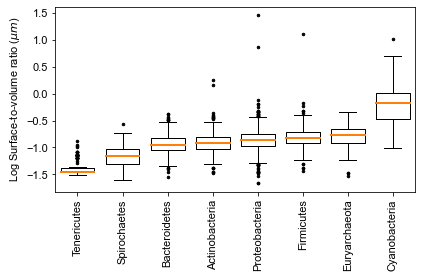

In [18]:
fig, ax = plt.subplots()
ax.boxplot(data, widths = 0.75, sym = 'k.')
ax.set_ylabel('Log Surface-to-volume ratio ($\\mu m$)')
plt.xticks([i + 1 for i in range(len(phyla))], phyla, rotation = 90)
plt.show()

### Kernel density estimation of svratio using `sklearn`

In [19]:
# Function for kernel density estimation
def kde(x, x_grid, bandwidth = 0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # Returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [20]:
# Function to adjust hyperparameter by cross-validation
def hyperp(x, mn, mx, cv):
    bandwidths = 10 ** np.linspace(mn, mx, 50)
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv = cv)
    grid.fit(x[:, np.newaxis])
    return grid.best_params_

Values of PDF are normalized, such that they are true probabilities and their sum gives one (i.e. a true probability!)

('Reject Ho', KstestResult(statistic=0.43573963334464666, pvalue=2.1516511814039476e-30), (-1.3815329901009918, 0.1385108345764097))

('Not enough evidence to reject Ho', KstestResult(statistic=0.12440356560526433, pvalue=0.05371796995358195), (-1.199614733188428, 0.21642649747837978))

('Not enough evidence to reject Ho', KstestResult(statistic=0.030456016110205764, pvalue=0.3269225780968321), (-0.9366865617157114, 0.16294276903109664))

('Not enough evidence to reject Ho', KstestResult(statistic=0.03686682218530235, pvalue=0.2501372779111911), (-0.9172451764507469, 0.17529382079420874))

('Reject Ho', KstestResult(statistic=0.03647665099252251, pvalue=0.008378243836978917), (-0.8642589340104183, 0.18191181405787313))

('Reject Ho', KstestResult(statistic=0.059847615749215155, pvalue=0.006172110956304181), (-0.8217029876390534, 0.17421156111840366))

('Not enough evidence to reject Ho', KstestResult(statistic=0.08656379950865412, pvalue=0.2491380179224047), (-0.8059983676675774, 0.208

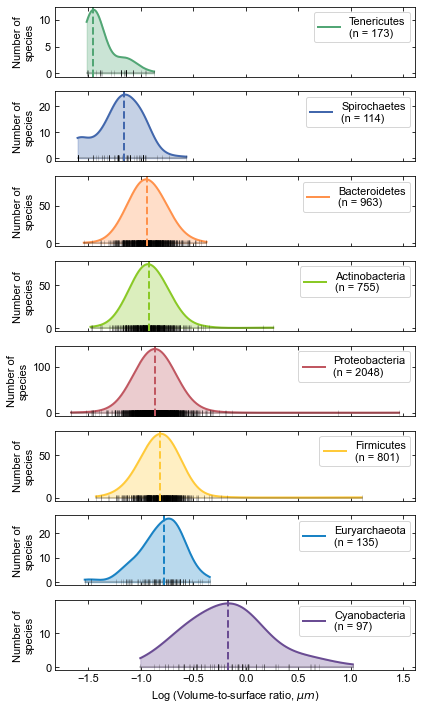

In [21]:
fig, ax = plt.subplots(len(phyla), 1, figsize = (6, 10), 
                       sharey = False, sharex = True)

for i, phy in enumerate(phyla):
    for j, f in enumerate(features):
        if phy == 'all':
            data = df[f].apply(np.log10).to_numpy()
        else:
            data = df[df['phylum'] == phy][f].apply(np.log10).to_numpy()
        
        # Compare with a normal distribution
        n = data.shape[0]    
        # Fit a normal distribution to data
        parameters = norm.fit(data)
        # Perform Kolmogorov-Smirnov test (goodness of fit)
        gft = kstest(data, 'norm', parameters)
        # Hypothesis testing (Ho: normal)
        print(f'{hypo_testing(gft[0], n), gft, parameters}\n')
        
        x_grid = np.linspace(data.min(), data.max(), data.shape[0])
        bw = hyperp(data, -1, 1, 5)
        pdf = kde(data, x_grid, bandwidth = bw['bandwidth'])
        
        counts, bins = np.histogram(data, bins = 'auto')
        widths = widths = bins[:-1] - bins[1:] 
        
        ax[i].plot(x_grid, pdf * len(data) * np.diff(bins[1:])[0], color = colors[i], lw = 2, 
                      label = f'{phy}\n(n = {data.shape[0]})')
        ax[i].fill_between(x_grid, pdf * len(data) * np.diff(bins[1:])[0], color = colors[i], alpha = 0.3)
        ax[i].plot(data, np.full_like(data, -0.0001), color = 'black', marker = '|',
                     alpha = 0.2)
        ax[i].axvline(x = np.median(data), color = colors[i], linestyle = 'dashed', linewidth = 2)
        
        ax[i].legend()
            
        ax[i].set_ylabel(f'Number of\nspecies')
        ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
        
        if i == len(phyla) - 1:
            ax[i].set_xlabel(f'Log (Volume-to-surface ratio, $\\mu m$)')

# plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.savefig('../figures_all/fig3.svg')   
plt.show()

[Ridge plot](https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/)

<ipython-input-22-4690ebe1017e>:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('../figures_all/fig3_ridge.svg')
/home/hsecaira/miniconda/envs/CellSize/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


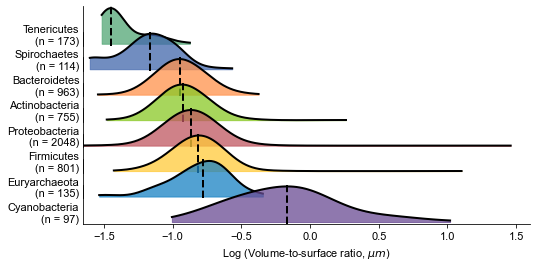

In [22]:
gs = grid_spec.GridSpec(len(phyla), 1)
fig = plt.figure(figsize = (8, 4))
ax_objs = []

for i, phy in enumerate(phyla):
    for j, f in enumerate(features):
        if phy == 'all':
            data = df[f].apply(np.log10).to_numpy()
        else:
            data = df[df['phylum'] == phy][f].apply(np.log10).to_numpy()

        x_grid = np.linspace(data.min(), data.max(), data.shape[0])
        bw = hyperp(data, -1, 1, 5)
        pdf = kde(data, x_grid, bandwidth=bw['bandwidth'])

        counts, bins = np.histogram(data, bins='auto')
        widths = bins[:-1] - bins[1:]

        # Create new axes object and append to the list
        ax_objs.append(fig.add_subplot(gs[i:i + 1, 0]))
        # Plot distribution
        plot = ax_objs[-1].plot(x_grid, pdf * len(data) * np.diff(bins[1:])[0], 
                                color = 'k', lw = 2)[0]
        
        # Access the x and y data from the Line2D object
        x = plot.get_xdata()
        y = plot.get_ydata()

        # Fill the space beneath the distributions
        ax_objs[-1].fill_between(x, y, color = colors[i], alpha = 0.75)
        
        # Set uniform x and y limits
        ax_objs[-1].set_xlim(-1.65, 1.6)

        # Text
        ax_objs[-1].text(-1.68, 0, f'{phy}\n(n = {data.shape[0]})', ha = 'right')
        ax_objs[-1].grid(visible = True, axis = 'y', which = 'major', linestyle = 'solid', color = 'b')

        # Make the background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)
        # Remove borders, axis ticks, and labels
        ax_objs[-1].set_yticks([])
        ax_objs[-1].set_yticklabels([])
            
        spines = ["top", "right", 'bottom']
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
            
        # Labels
        if i == len(phyla) - 1:
            ax_objs[-1].set_xlabel(f'Log (Volume-to-surface ratio, $\\mu m$)')
            ax_objs[-1].spines['bottom'].set_visible(True)
        else:
            ax_objs[-1].set_xticklabels([])
            ax_objs[-1].set_xticks([])
            
        ax_objs[-1].axvline(x = np.median(data), color = 'k', linestyle = 'dashed', linewidth = 2)
        
            
gs.update(hspace = -0.35)
plt.savefig('../figures_all/fig3_ridge.svg') 
plt.show()

### Statistical tests

Comparison between phyla

In [23]:
res = []
for i, j in combinations(phyla[1:], 2):
    phylum_i = df[df['phylum'] == i]['svratio'].apply(np.log10)
    phylum_j = df[df['phylum'] == j]['svratio'].apply(np.log10)
    stat, pval = kstest(phylum_i, phylum_j)
    res.append([f'{i}_{j}', stat, pval])
    #print(f'KS test statistic: {stat}, p-value: {pval}, {hypo_testing(stat, phylum_i.shape[0])}, {i}, {j}')

In [24]:
dfr = pd.DataFrame(res, columns = ['pair', 'KS_statistic', 'pvalue']).set_index('pair')
dfr.shape

(21, 2)

Comparison of each phylum against a normal distribution

In [25]:
res = []
for phy in phyla:
    data = df[df['phylum'] == phy]['svratio'].apply(np.log10).to_numpy()
    # Fit a normal distribution to data
    parameters = norm.fit(data)
    # Perform Kolmogorov-Smirnov test (goodness of fit)
    gft = kstest(data, 'norm', parameters)
    # Kurtosis test
    kurt = kurtosis(data)
    # Skewness test
    skw = skew(data)
    # Append results
    res.append([phy, parameters[0], parameters[1], 10 ** (parameters[0]), 10 ** (parameters[1]), gft[0], gft[1], kurt, skw])

In [26]:
dfr_norm = pd.DataFrame(res, 
        columns = ['phylum', 'mean', 'std', 'mean_lin', 'std_lin', 
                   'KS_statistic', 'pvalue', 'kurtosis', 'skewness']).set_index('phylum')
dfr_norm.shape

(8, 8)

In [27]:
dfr_norm

,mean,std,mean_lin,std_lin,KS_statistic,pvalue,kurtosis,skewness
phylum,,,,,,,,
Tenericutes,-1.381533,0.138511,0.041540,1.375659,0.435740,2.151651e-30,1.241478,1.598409
Spirochaetes,-1.199615,0.216426,0.063152,1.645987,0.124404,5.371797e-02,-0.051643,-0.306595
Bacteroidetes,-0.936687,0.162943,0.115695,1.455267,0.030456,3.269226e-01,0.289687,0.156241
Actinobacteria,-0.917245,0.175294,0.120991,1.497248,0.036867,2.501373e-01,4.331611,0.757359
Proteobacteria,-0.864259,0.181912,0.136691,1.520239,0.036477,8.378244e-03,17.312277,1.396966
Firmicutes,-0.821703,0.174212,0.150764,1.493522,0.059848,6.172111e-03,18.359688,1.501847
Euryarchaeota,-0.805998,0.208082,0.156315,1.614665,0.086564,2.491380e-01,1.286800,-0.803439
Cyanobacteria,-0.177362,0.379316,0.664718,2.395056,0.093287,3.458071e-01,0.379855,0.491791


In [28]:
dfr_norm.sort_values(['mean'])

,mean,std,mean_lin,std_lin,KS_statistic,pvalue,kurtosis,skewness
phylum,,,,,,,,
Tenericutes,-1.381533,0.138511,0.041540,1.375659,0.435740,2.151651e-30,1.241478,1.598409
Spirochaetes,-1.199615,0.216426,0.063152,1.645987,0.124404,5.371797e-02,-0.051643,-0.306595
Bacteroidetes,-0.936687,0.162943,0.115695,1.455267,0.030456,3.269226e-01,0.289687,0.156241
Actinobacteria,-0.917245,0.175294,0.120991,1.497248,0.036867,2.501373e-01,4.331611,0.757359
Proteobacteria,-0.864259,0.181912,0.136691,1.520239,0.036477,8.378244e-03,17.312277,1.396966
Firmicutes,-0.821703,0.174212,0.150764,1.493522,0.059848,6.172111e-03,18.359688,1.501847
Euryarchaeota,-0.805998,0.208082,0.156315,1.614665,0.086564,2.491380e-01,1.286800,-0.803439
Cyanobacteria,-0.177362,0.379316,0.664718,2.395056,0.093287,3.458071e-01,0.379855,0.491791


In [29]:
med = {}
for phy in phyla[1:]:
    data = df[df['phylum'] == phy]['svratio'].apply(np.log10).to_numpy()
#     print(f'Phylum {phy}, median {np.median(data)}')
    med[phy] = np.median(data)

In [30]:
sorted(med.items(), reverse = True)

[('Spirochaetes', -1.1628679368480896),
 ('Proteobacteria', -0.864262482552089),
 ('Firmicutes', -0.816899703257433),
 ('Euryarchaeota', -0.7781512503836436),
 ('Cyanobacteria', -0.16636174254808891),
 ('Bacteroidetes', -0.9465556807730339),
 ('Actinobacteria', -0.9263198277104184)]

### Correct p-values due to multiple testing using Benjamini/Hochberg

Comparison between phyla

In [31]:
pvals_corrected = multipletests(dfr['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]

In [32]:
dfr['pvalue_corrected'] = pvals_corrected

In [33]:
dfr.head()

,KS_statistic,pvalue,pvalue_corrected
pair,,,
Spirochaetes_Bacteroidetes,0.571842,4.338649e-32,1.138895e-31
Spirochaetes_Actinobacteria,0.592146,1.268991e-33,3.806972e-33
Spirochaetes_Proteobacteria,0.682754,1.221245e-15,1.831868e-15
Spirochaetes_Firmicutes,0.790131,4.012012e-67,2.808408e-66
Spirochaetes_Euryarchaeota,0.766862,1.083925e-38,3.793738e-38


In [34]:
dfr.to_csv('per_phylum_distribution.csv', sep = '\t')

In [35]:
dfr[dfr['pvalue_corrected'] > 0.05]

,KS_statistic,pvalue,pvalue_corrected
pair,,,
Bacteroidetes_Actinobacteria,0.063443,0.062724,0.062724


In [36]:
dfr[dfr['pvalue_corrected'] < 0.01].shape

(19, 3)

Comparison of each phylum against a normal distribution

In [37]:
pvals_corrected = multipletests(dfr_norm['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]

In [38]:
dfr_norm['pvalue_corrected'] = pvals_corrected

In [39]:
dfr_norm

,mean,std,mean_lin,std_lin,KS_statistic,pvalue,kurtosis,skewness,pvalue_corrected
phylum,,,,,,,,,
Tenericutes,-1.381533,0.138511,0.041540,1.375659,0.435740,2.151651e-30,1.241478,1.598409,1.721321e-29
Spirochaetes,-1.199615,0.216426,0.063152,1.645987,0.124404,5.371797e-02,-0.051643,-0.306595,1.074359e-01
Bacteroidetes,-0.936687,0.162943,0.115695,1.455267,0.030456,3.269226e-01,0.289687,0.156241,3.458071e-01
Actinobacteria,-0.917245,0.175294,0.120991,1.497248,0.036867,2.501373e-01,4.331611,0.757359,3.335164e-01
Proteobacteria,-0.864259,0.181912,0.136691,1.520239,0.036477,8.378244e-03,17.312277,1.396966,2.234198e-02
Firmicutes,-0.821703,0.174212,0.150764,1.493522,0.059848,6.172111e-03,18.359688,1.501847,2.234198e-02
Euryarchaeota,-0.805998,0.208082,0.156315,1.614665,0.086564,2.491380e-01,1.286800,-0.803439,3.335164e-01
Cyanobacteria,-0.177362,0.379316,0.664718,2.395056,0.093287,3.458071e-01,0.379855,0.491791,3.458071e-01


In [40]:
dfr_norm.to_csv('per_phylum_distribution_normal.csv', sep = '\t')

In [41]:
dfr_norm[dfr_norm['pvalue_corrected'] < 0.05]

,mean,std,mean_lin,std_lin,KS_statistic,pvalue,kurtosis,skewness,pvalue_corrected
phylum,,,,,,,,,
Tenericutes,-1.381533,0.138511,0.041540,1.375659,0.435740,2.151651e-30,1.241478,1.598409,1.721321e-29
Proteobacteria,-0.864259,0.181912,0.136691,1.520239,0.036477,8.378244e-03,17.312277,1.396966,2.234198e-02
Firmicutes,-0.821703,0.174212,0.150764,1.493522,0.059848,6.172111e-03,18.359688,1.501847,2.234198e-02


QQ plots

In [42]:
phyla = ['Tenericutes', 'Spirochaetes', 'Bacteroidetes', 'Actinobacteria', 'Proteobacteria',
       'Firmicutes', 'Euryarchaeota', 'Cyanobacteria']

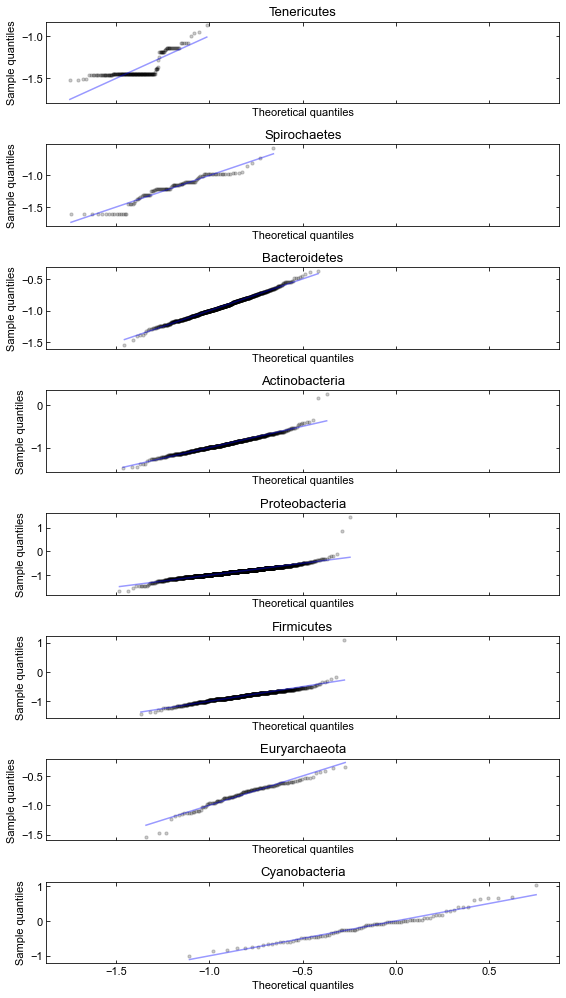

In [43]:
fig, ax = plt.subplots(len(phyla), 1, figsize = (8, 14), 
                       sharey = False, sharex = True)
for i, phy in enumerate(phyla):
    if phy == 'all':
        data = df['svratio'].apply(np.log10).to_numpy()
    else:
        data = df[df['phylum'] == phy]['svratio'].apply(np.log10).to_numpy()
    # Fit a normal distribution to data
    parameters = norm.fit(data)
    # Calculate quantiles for QQ plot
    qq = probplot(data, sparams = (parameters[0], parameters[1]), dist = 'norm')
    ax[i].scatter(qq[0][0], qq[0][1], alpha = 0.2, color = 'black', s = 10)
    ax[i].plot(qq[0][0], qq[0][0], color = 'blue', alpha = 0.4)
    ax[i].set_xlabel('Theoretical quantiles')
    ax[i].set_ylabel('Sample quantiles')
    ax[i].set_title(f'{phy}')
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
    
plt.savefig('../figures_all/qqplot_phylum_all.svg') 
plt.show()

Removing the giant bacteria from Proteobacteria and Firmicutes

In [44]:
df_proteo = df[df['phylum'] == 'Proteobacteria']
df_prote_removed = df_proteo[~df_proteo['genus'].isin(['Thiomargarita'])]

In [45]:
df_firmi = df[df['phylum'] == 'Firmicutes']
df_firmi_removed = df_firmi[~df_firmi['genus'].isin(['Epulopiscium'])]

In [46]:
data_removed = [df_prote_removed, df_firmi_removed]

In [47]:
colors = ['#c05761', '#ffca3a']

('Not enough evidence to reject Ho', KstestResult(statistic=0.020249691126699942, pvalue=0.3662228645189983), (-0.8662450246621146, 0.17029729995847578))

('Not enough evidence to reject Ho', KstestResult(statistic=0.04594541866382712, pvalue=0.06615520589458879), (-0.8241086918157431, 0.1604739468922164))



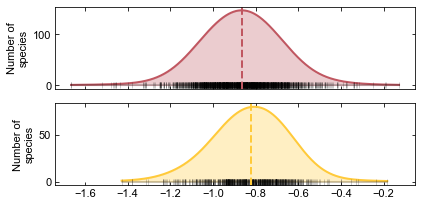

In [48]:
fig, ax = plt.subplots(2, 1, figsize = (6, 3), 
                       sharey = False, sharex = True)

for i, phy in enumerate(['Proteobacteria', 'Firmicutes']):
    for j, f in enumerate(features):
        data = data_removed[i][f].apply(np.log10).to_numpy()
        
        # Compare with a normal distribution
        n = data.shape[0]    
        # Fit a normal distribution to data
        parameters = norm.fit(data)
        # Perform Kolmogorov-Smirnov test (goodness of fit)
        gft = kstest(data, 'norm', parameters)
        # Hypothesis testing (Ho: normal)
        print(f'{hypo_testing(gft[0], n), gft, parameters}\n')
        
        x_grid = np.linspace(data.min(), data.max(), data.shape[0])
        bw = hyperp(data, -1, 1, 5)
        counts, bins = np.histogram(data, bins = 'auto')
        widths = widths = bins[:-1] - bins[1:] 
        pdf = kde(data, x_grid, bandwidth = bw['bandwidth'])
        
        ax[i].plot(x_grid, pdf * len(data) * np.diff(bins[1:])[0], color = colors[i], lw = 2, 
                      label = f'{phy}\n(n = {data.shape[0]})')
        ax[i].fill_between(x_grid, pdf * len(data) * np.diff(bins[1:])[0], color = colors[i], alpha = 0.3)
        ax[i].plot(data, np.full_like(data, -0.0001), color = 'black', marker = '|',
                     alpha = 0.2)
        ax[i].axvline(x = np.mean(data), color = colors[i], linestyle = 'dashed', linewidth = 2)
            
        ax[i].set_ylabel(f'Number of\nspecies')
        ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
        
        if i == len(phyla) - 1:
            ax[i].set_xlabel(f'Log (Volume-to-surface ratio, $\\mu m$)')

plt.savefig('../figures_all/fig3_removed_outliers.svg')   
plt.show()

## Kruskal-Wallis test - per phylum

Assumptions: similar shape and equal variance among groups:

* Empricial distributions have a similar shape: bell-shape
* Test equality of variance with Levene's test

Levene's test

In [49]:
phyla = ['Tenericutes', 'Spirochaetes', 'Bacteroidetes', 'Actinobacteria', 'Proteobacteria',
       'Firmicutes', 'Euryarchaeota', 'Cyanobacteria']
phylas = []
for phy in phyla:
    phylas.append(df[df['phylum'] == phy]['svratio'].apply(np.log10).to_numpy())
    

In [50]:
levene(phylas[0], phylas[1], phylas[2], phylas[3], phylas[4], phylas[5], phylas[6], phylas[7])

LeveneResult(statistic=33.41581947111851, pvalue=8.947085517017739e-46)

Variance is different among groups!

Kruskal-Wallis test

In [51]:
kruskal(phylas[0], phylas[1], phylas[2], phylas[3], phylas[4], phylas[5], phylas[6], phylas[7])

KruskalResult(statistic=1133.5119985596039, pvalue=1.6781376313775432e-240)

Mann-Whitney test (non-parametric) to test differences in the location between distribution

In [52]:
res = []
for i, j in combinations(phyla, 2):
    phylum_i = df[df['phylum'] == i]['svratio'].apply(np.log10)
    phylum_j = df[df['phylum'] == j]['svratio'].apply(np.log10)
    stat, pval = mannwhitneyu(phylum_i, phylum_j)
#     stat, pval = ttest_ind(phylum_i, phylum_j, equal_var = False)
    res.append([f'{i}_{j}', stat, pval])

In [53]:
dfr_mw = pd.DataFrame(res, columns = ['pair', 'MW_statistic', 'pvalue']).set_index('pair')
dfr_mw.shape

(28, 2)

Correct p-values using Benjamini-Hochberg

In [54]:
pvals_corrected = multipletests(dfr_mw['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
dfr_mw['pvalue_corrected'] = pvals_corrected

In [55]:
dfr_mw.to_csv('per_phylum_distribution_mw.csv', sep = '\t')

In [56]:
dfr_mw

,MW_statistic,pvalue,pvalue_corrected
pair,,,
Tenericutes_Spirochaetes,4914.0,9.528264e-14,1.159963e-13
Tenericutes_Bacteroidetes,5243.5,2.715803e-86,2.534750e-85
Tenericutes_Actinobacteria,3810.5,9.839135e-84,6.887395e-83
Tenericutes_Proteobacteria,6782.5,1.569223e-98,4.393824e-97
Tenericutes_Firmicutes,1525.5,4.369576e-91,6.117406e-90
Tenericutes_Euryarchaeota,786.5,1.080533e-46,2.521243e-46
Tenericutes_Cyanobacteria,4.5,8.060054e-45,1.736012e-44
Spirochaetes_Bacteroidetes,17589.5,7.713281e-33,1.349824e-32
Spirochaetes_Actinobacteria,12235.0,3.132825e-35,5.847940e-35


In [57]:
dfr_mw[dfr_mw['pvalue_corrected'] > 0.05]

,MW_statistic,pvalue,pvalue_corrected
pair,,,
